In this Jupiter Notebook we performed some basic EDA in order to gain perspective on the distribution of classes and the boxes. 

In addition in this part we loaded pre-trained models and tuned them using the little labeled data we had. 

We saved all of the models inside the directory "Trained models" to load them and compare them further inside "comparing_models.ipynb" file.

# Packages

In [1]:
import cv2
import os
import json
import glob
import shutil

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import albumentations as A

from ultralytics import YOLO

/anaconda/envs/py38_default/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Other Utilities

In [2]:
# Working directories
main_root = "/datashare/HW1/"
labels_dir = main_root + "labeled_image_data/labels/"
imgs_dir = main_root + "labeled_image_data/images/"
labels_train_dir = labels_dir + "train/"
imgs_train_dir = imgs_dir + "train/"
labels_val_dir = labels_dir + "val/"
imgs_val_dir = imgs_dir + "val/"
id_videos_dir = main_root + "id_video_data/"
ood_videos_dir = main_root + "ood_video_data/"

os.makedirs("trained_models", exist_ok=True) # to save our trained models
trained_model_dir = "trained_models/"

# This directory was used to save custom augmented and pooled pictures to train final model on it 
data_img_dir_train = "data/images/train/"
data_lbl_dir_train = "data/labels/train/"
data_img_dir_val = "data/images/val/"
data_lbl_dir_val = "data/labels/val/"
os.makedirs(data_img_dir_train, exist_ok=True) 
os.makedirs(data_lbl_dir_train, exist_ok=True) 
os.makedirs(data_img_dir_val, exist_ok=True) 
os.makedirs(data_lbl_dir_val, exist_ok=True) 

In [3]:
# utilities for mapping the claasses
categories = {
    0: "Empty",
    1: "Tweezers",
    2: "Needle_driver"
}

# assigning a color to represent each given class
colors = {
    0: (255, 0, 0),   # red
    1: (0, 255, 0),   # green
    2: (0, 0, 255)    # blue
}

In [4]:
# funstion that copies files in needed structure
def copy_files(from_img_path, from_label_path, to_img_path, to_label_path):
    for f in os.listdir(from_img_path):
        base = os.path.splitext(f)[0]
        shutil.copy2(os.path.join(from_img_path, f), os.path.join(to_img_path, f))
        shutil.copy2(os.path.join(from_label_path, base + ".txt"), os.path.join(to_label_path, base + ".txt"))

In [5]:
# copying the train set as well so the model doesn't forget its original dataset that has real values
copy_files(imgs_val_dir, labels_val_dir, data_img_dir_val, data_lbl_dir_val)
copy_files(imgs_train_dir, labels_train_dir, data_img_dir_val, data_lbl_dir_val)

# EDA

## Exploring json

In [6]:
json_file = main_root + "labeled_image_data/notes.json"
with open(json_file, 'r') as f:
    notes = json.load(f)

print(json.dumps(notes, indent=2)) 

{
  "categories": [
    {
      "id": 0,
      "name": "Empty"
    },
    {
      "id": 1,
      "name": "Tweezers"
    },
    {
      "id": 2,
      "name": "Needle_driver"
    }
  ],
  "info": {
    "year": 2024,
    "version": "1.0",
    "contributor": "Label Studio"
  }
}


## Exploring labels

In [7]:
def analyze_label_distribution(label_dir):
    counter = {0:0, 1:0, 2:0}
    bbox_sizes = []

    for file in glob.glob(os.path.join(label_dir, '*.txt')):
        with open(file) as f:
            for line in f:
                label, xc, yc, w, h = map(float, line.strip().split())
                counter[int(label)] += 1
                bbox_sizes.append((w, h))

    print("Class distribution:", counter)
    return bbox_sizes, counter

In [8]:
sizes, label_stat = analyze_label_distribution(labels_train_dir)

Class distribution: {0: 26, 1: 54, 2: 55}


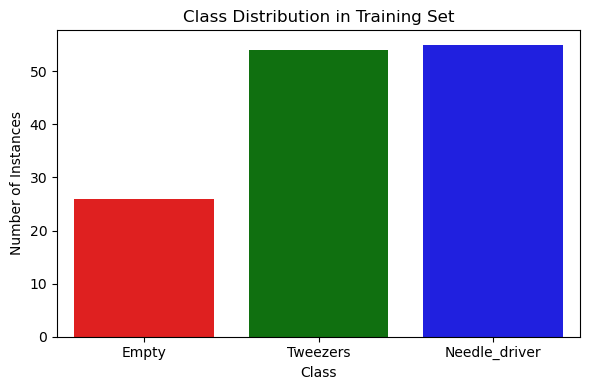

In [9]:
label_stat_df = pd.DataFrame(list(label_stat.items()), columns=["Class", "Count"])
label_stat_df["Class Name"] = label_stat_df["Class"].map(categories)

sizes_df = pd.DataFrame(sizes, columns=["Width", "Height"])
plt.figure(figsize=(6, 4))
sns.barplot(x="Class Name", y="Count", data=label_stat_df,hue="Class Name",
            palette=["red", "green", "blue"])
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Instances")
plt.xlabel("Class")
plt.tight_layout()
plt.show()


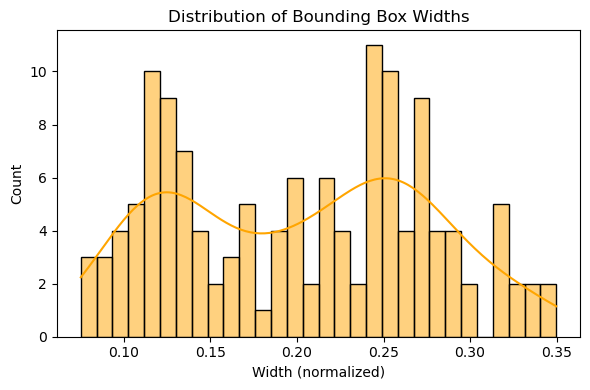

In [10]:
plt.figure(figsize=(6, 4))
sns.histplot(sizes_df["Width"], kde=True, color="orange", bins=30)
plt.title("Distribution of Bounding Box Widths")
plt.xlabel("Width (normalized)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

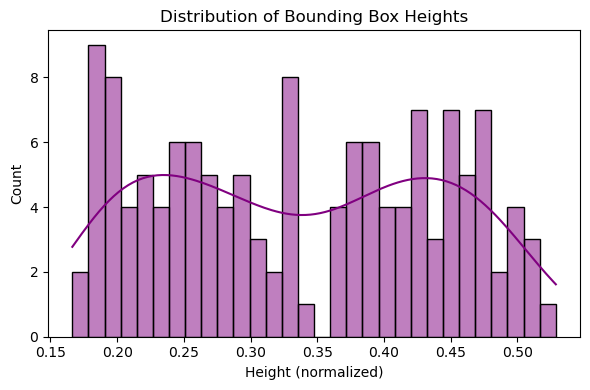

In [11]:
plt.figure(figsize=(6, 4))
sns.histplot(sizes_df["Height"], kde=True, color="purple", bins=30)
plt.title("Distribution of Bounding Box Heights")
plt.xlabel("Height (normalized)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

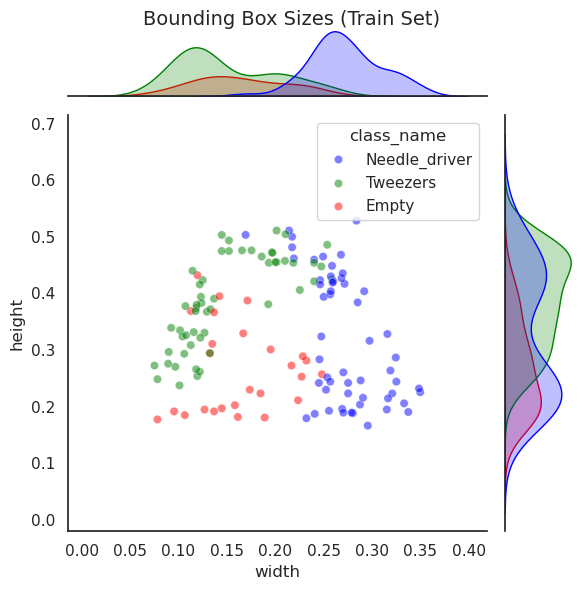

In [12]:
labels_per_box = []
for file in glob.glob(os.path.join(labels_train_dir, '*.txt')):
    with open(file) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            label = int(float(parts[0]))
            labels_per_box.append(label)

categories = {0: "Empty", 1: "Tweezers", 2: "Needle_driver"}
df = pd.DataFrame(sizes, columns=['width', 'height'])
df['label'] = labels_per_box
df['class_name'] = df['label'].map(categories)
sns.set(style="white")
g = sns.jointplot(
    data=df,
    x="width",
    y="height",
    hue="class_name",
    palette={"Empty": "red", "Tweezers": "green", "Needle_driver": "blue"},
    alpha=0.5
)
g.fig.suptitle("Bounding Box Sizes (Train Set)", fontsize=14)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)  # for title spacing
plt.show()


## Exploring images with YOLO boxes

In [13]:
image_path = imgs_train_dir + "06e0aac8-output_0037.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.shape

(2160, 3840, 3)

We will have to reshape it in training process as this is too large to process efectievely

In [14]:
def draw_yolo_boxes(image_path, label_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    h, w, _ = image.shape

    boxes = []
    # Loading the boxes from txt file
    with open(label_path, "r") as f:
        for line in f.readlines():
            class_id, x_center, y_center, box_w, box_h = map(float, line.strip().split())
            boxes.append((int(class_id), x_center, y_center, box_w, box_h))
    # each line represents a label, coordinates of the center: x, y , width and height        
    for class_id, x_center, y_center, box_w, box_h in boxes:
        x_center *= w
        y_center *= h
        box_w *= w
        box_h *= h

        x1 = int(x_center - box_w / 2)
        y1 = int(y_center - box_h / 2)
        x2 = int(x_center + box_w / 2)
        y2 = int(y_center + box_h / 2)

        color = colors[class_id] 
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

        label = categories[class_id]
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [15]:
with open(labels_train_dir+"dc469e1a-frame_0895.txt", 'r') as f:
    lines = f.readlines()
    for line in lines:
        print(line.strip())

2 0.47444581280788173 0.7493158182813354 0.2789408866995074 0.18938149972632728
0 0.5132389162561576 0.6081007115489874 0.166871921182266 0.3295019157088122


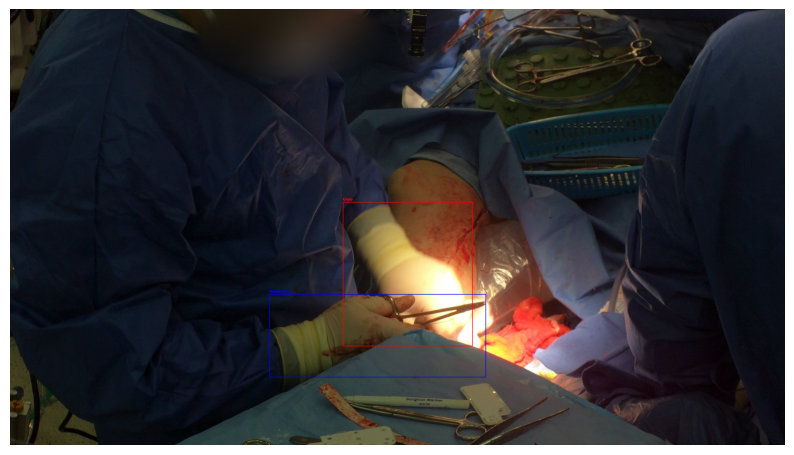

In [16]:
draw_yolo_boxes(imgs_train_dir+"dc469e1a-frame_0895.jpg", labels_train_dir+"dc469e1a-frame_0895.txt")

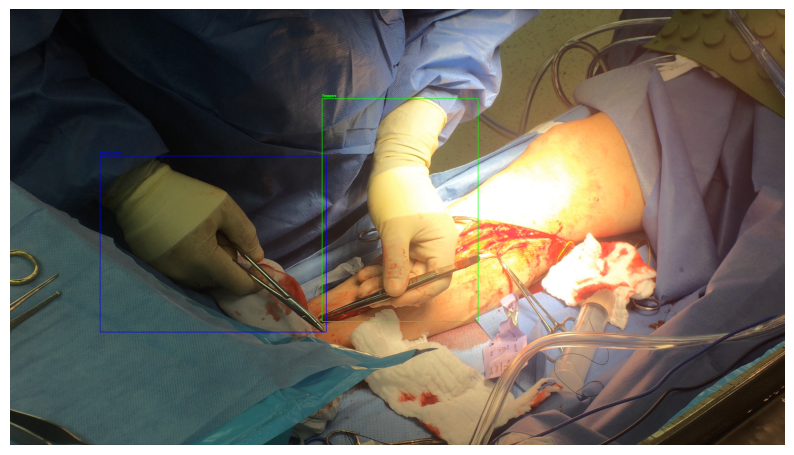

In [17]:
image_path = imgs_train_dir + "06e0aac8-output_0037.png"
label_path = labels_train_dir + "06e0aac8-output_0037.txt"

draw_yolo_boxes(image_path, label_path)

## Exploring videos

In [18]:
def show_video_sample(video_path, step=100):
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or frame_idx > 300:  # limit for speed
            break
        if frame_idx % step == 0:
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.title(f"Frame {frame_idx}")
            plt.axis('off')
            plt.show()
        frame_idx += 1
    cap.release()

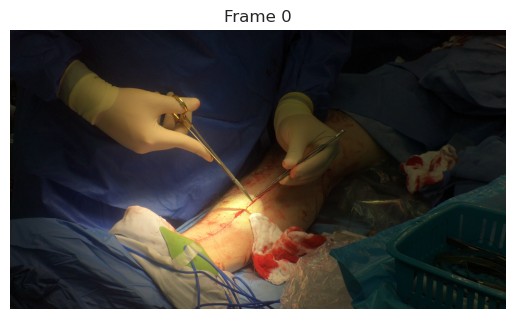

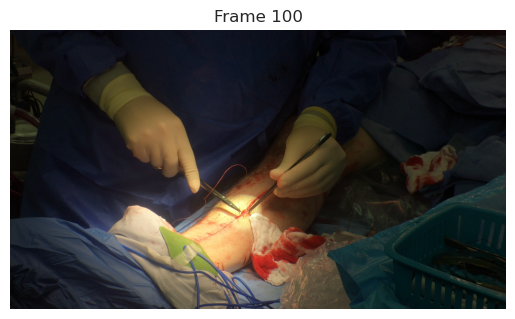

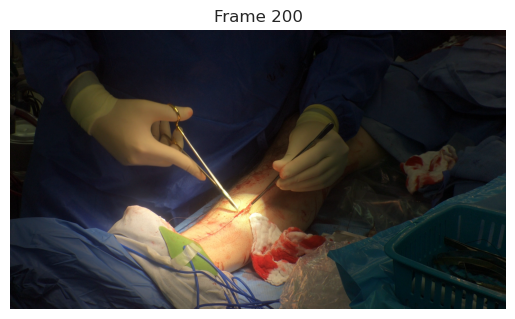

In [19]:
show_video_sample(ood_videos_dir + "surg_1.mp4")

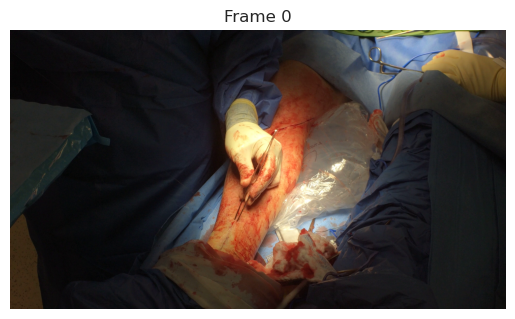

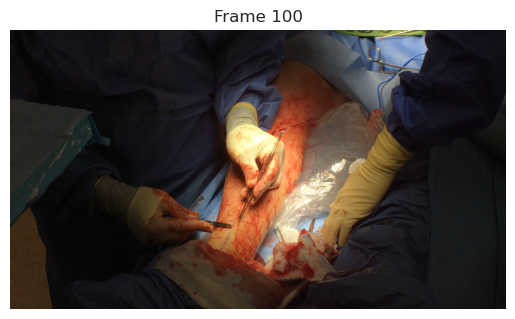

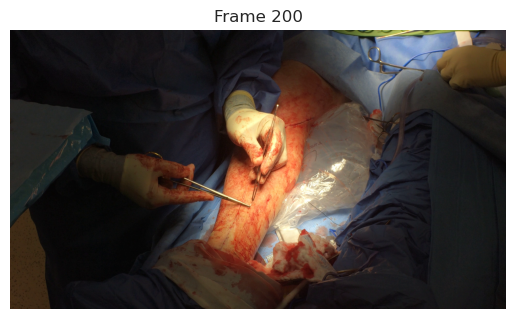

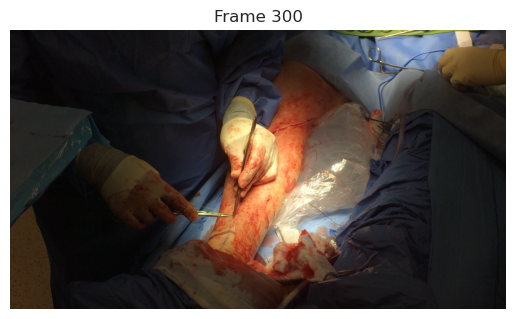

In [20]:
show_video_sample(id_videos_dir + "20_2_24_1.mp4")

# Base model (YOLOv9 without augmentations)

Here we used basic augmentations that are built in. 

This includes: 
- Random scale
- Random brightness/contrast
- Horizontal Flip

It dosnt't include another augmentations that can be helpful in this domain.

In [21]:
# %pip uninstall torch torchvision torchaudio -y
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [22]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla V100-PCIE-16GB


Very small and lightweight model

In [23]:
model = YOLO('yolov9c.pt') # tried c (for compact)

model.train(
    data = 'surgical.yaml',  
    epochs = 100, 
    imgsz = 640,
    batch = 16,              
    name = 'base_model1',
    workers = 8,
    patience = 20 # stopping early of no improvement is made in 10 epochs tried and failed:(
    )

model.save(trained_model_dir + "base_model1.pt")

100%|██████████| 49.4M/49.4M [00:00<00:00, 289MB/s]


New https://pypi.org/project/ultralytics/8.3.147 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.146 🚀 Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=surgical.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov9c.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=base_model1, nbs=64, nms=False, opset=None, optimize=

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    212864  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 1]        
  3                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  4                  -1  1    847616  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 1]       
  5                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  6                  -1  1   2857472  ultralytics.nn.modules.block.RepNCSPELAN4    [512, 512, 512, 256, 1]       
  7                  -1  1    656384  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 191MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.4±0.4 ms, read: 44.9±26.3 MB/s, size: 5836.1 KB)


train: Scanning /datashare/HW1/labeled_image_data/labels/train... 61 images, 0 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:02<00:00, 27.06it/s]

WARNING ⚠️ train: Cache directory /datashare/HW1/labeled_image_data/labels is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.2±0.3 ms, read: 35.0±15.2 MB/s, size: 3348.1 KB)


val: Scanning /datashare/HW1/labeled_image_data/labels/val... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 24.58it/s]

WARNING ⚠️ val: Cache directory /datashare/HW1/labeled_image_data/labels is not writeable, cache not saved.


Plotting labels to runs/detect/base_model1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)


2025/06/02 22:57:04 INFO mlflow.tracking.fluent: Experiment with name '/Shared/Ultralytics' does not exist. Creating a new experiment.


MLflow: logging run_id(e2b052a78fb7419aaf27a67da2648096) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 6 dataloader workers
Logging results to runs/detect/base_model1
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      9.96G      1.596      4.198      1.777         56        640: 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

                   all         10         22    0.00232        0.3    0.00934     0.0016



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100        10G       1.65      4.211      1.852         64        640: 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]

                   all         10         22       0.72        0.5      0.697      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      10.2G      1.076      2.044      1.339         48        640: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


                   all         10         22      0.675       0.58      0.631      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      10.2G     0.9933      1.499       1.27         55        640: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.76it/s]

                   all         10         22      0.491      0.533      0.552      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      10.2G     0.9087       1.11      1.124         69        640: 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.34it/s]

                   all         10         22      0.606      0.821      0.596      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      10.2G     0.9037      1.035      1.119         53        640: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]

                   all         10         22      0.757      0.733      0.773      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      10.2G     0.8616      1.038      1.125         64        640: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]

                   all         10         22      0.546      0.759      0.791      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      10.2G     0.9715      1.049      1.233         50        640: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]

                   all         10         22      0.771      0.433       0.58      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      10.2G     0.9447     0.9442      1.141         63        640: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]

                   all         10         22      0.377      0.567      0.442      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      10.2G     0.8658     0.9295      1.192         56        640: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]

                   all         10         22      0.817      0.637      0.585      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      10.2G     0.8653     0.7864      1.114         79        640: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]

                   all         10         22      0.666      0.833      0.837      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      10.2G     0.8831     0.8843        1.1         50        640: 100%|██████████| 4/4 [00:01<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]

                   all         10         22     0.0358      0.607     0.0382     0.0212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      10.2G     0.9364     0.9028      1.149         42        640: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]

                   all         10         22      0.236      0.733      0.262      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      10.2G      0.866     0.8607      1.123         47        640: 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]

                   all         10         22      0.228      0.733      0.272       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      10.2G     0.8644     0.7909      1.108         58        640: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]

                   all         10         22      0.481      0.767      0.516      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      10.2G     0.8553     0.8016      1.175         53        640: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]

                   all         10         22       0.49      0.733      0.515      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      10.2G     0.8514      0.709      1.057         60        640: 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]

                   all         10         22      0.403      0.867      0.675      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      10.2G     0.8188     0.6968      1.084         74        640: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]

                   all         10         22      0.331      0.778      0.474      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      10.2G     0.9376     0.7454      1.149         61        640: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]

                   all         10         22      0.313      0.702      0.468      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      10.2G     0.9069     0.7129       1.18         53        640: 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]

                   all         10         22       0.22      0.854      0.409      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      10.2G     0.9258     0.7448      1.135         65        640: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]

                   all         10         22      0.405      0.733      0.439      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      10.2G     0.8715     0.6858      1.126         57        640: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]

                   all         10         22       0.38      0.567      0.524      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      10.2G     0.9175     0.6783      1.115         61        640: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]

                   all         10         22      0.488        0.7      0.707      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      10.2G     0.8808     0.6468       1.06         71        640: 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]

                   all         10         22      0.543        0.8      0.622      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      10.2G     0.8799     0.7313       1.14         47        640: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]

                   all         10         22      0.778      0.418      0.474      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      10.2G     0.8086     0.7085      1.073         58        640: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]

                   all         10         22      0.721      0.522      0.563      0.405
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 6, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



26 epochs completed in 0.024 hours.
Optimizer stripped from runs/detect/base_model1/weights/last.pt, 51.6MB
Optimizer stripped from runs/detect/base_model1/weights/best.pt, 51.6MB

Validating runs/detect/base_model1/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
YOLOv9c summary (fused): 156 layers, 25,321,561 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


                   all         10         22      0.757      0.733      0.773      0.628
                 Empty          2          2       0.38        0.5       0.62      0.471
              Tweezers          9         10      0.996        0.9      0.896      0.746
         Needle_driver          9         10      0.896        0.8      0.803      0.666
Speed: 0.1ms preprocess, 3.0ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/base_model1
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


Small model, perfect for Real-time predictions

In [24]:
model = YOLO('yolov9s.pt')

model.train(
    data = 'surgical.yaml',  
    epochs = 50, 
    imgsz = 640,
    batch = 16,              
    name = 'base_model2',
    workers = 8,
    )

model.save(trained_model_dir + "base_model2.pt")

100%|██████████| 14.7M/14.7M [00:00<00:00, 300MB/s]


New https://pypi.org/project/ultralytics/8.3.147 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.146 🚀 Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=surgical.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov9s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=base_model2, nbs=64, nms=False, opset=None, optimize=F

train: Scanning /datashare/HW1/labeled_image_data/labels/train... 61 images, 0 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:02<00:00, 29.47it/s]

WARNING ⚠️ train: Cache directory /datashare/HW1/labeled_image_data/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 5.7±12.0 ms, read: 37.6±21.2 MB/s, size: 3348.1 KB)


val: Scanning /datashare/HW1/labeled_image_data/labels/val... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 24.30it/s]

WARNING ⚠️ val: Cache directory /datashare/HW1/labeled_image_data/labels is not writeable, cache not saved.


Plotting labels to runs/detect/base_model2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
MLflow: logging run_id(83c90e3c68d4408e8cf0381069bacb03) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 6 dataloader workers
Logging results to runs/detect/base_model2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.29G      1.853      4.493       1.99         56        640: 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

                   all         10         22    0.00421        0.5    0.00468    0.00188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.32G      1.804      4.202      1.938         64        640: 100%|██████████| 4/4 [00:01<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]

                   all         10         22       0.45      0.133        0.2      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.35G       1.41      2.543      1.568         48        640: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

                   all         10         22      0.401      0.433      0.494      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.35G      1.218      1.965      1.455         55        640: 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]

                   all         10         22      0.838      0.463      0.563      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.36G     0.9914      1.357      1.269         69        640: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

                   all         10         22      0.818      0.873      0.902      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.37G      1.012       1.28      1.242         53        640: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

                   all         10         22      0.594      0.707       0.72      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.37G     0.9503      1.028      1.248         64        640: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]

                   all         10         22      0.701      0.896      0.792      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.37G     0.9165      1.046       1.26         50        640: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         10         22      0.609      0.733      0.649      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.37G     0.8387     0.9219      1.155         63        640: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]

                   all         10         22        0.6      0.767      0.665      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.37G     0.8232     0.9072       1.18         56        640: 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.75it/s]

                   all         10         22      0.733      0.708       0.63      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.37G     0.8156     0.7827      1.084         79        640: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]

                   all         10         22      0.736        0.7       0.73      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.37G      0.825     0.8003      1.114         50        640: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all         10         22        0.9      0.732      0.724      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.37G     0.8754     0.8657      1.159         42        640: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]

                   all         10         22      0.899      0.692      0.747      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.37G      0.813     0.7618      1.106         47        640: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.80it/s]

                   all         10         22      0.665      0.733      0.658      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.37G     0.8421     0.7389      1.095         58        640: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.75it/s]

                   all         10         22      0.591      0.722      0.663      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.37G     0.8503     0.7952      1.167         53        640: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.80it/s]

                   all         10         22      0.922        0.7      0.774      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.37G     0.7813     0.6561      1.052         60        640: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.77it/s]

                   all         10         22      0.812      0.858      0.835      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.37G     0.8219     0.6759      1.091         74        640: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.79it/s]

                   all         10         22      0.709      0.884      0.738      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.37G     0.8045     0.6317      1.084         61        640: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.82it/s]

                   all         10         22      0.763      0.884      0.799      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.37G     0.7745     0.6396       1.08         53        640: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.52it/s]

                   all         10         22       0.86      0.894      0.788      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.37G     0.7761     0.6299      1.106         65        640: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.85it/s]

                   all         10         22      0.843      0.889        0.8      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.37G     0.7607     0.6078      1.075         57        640: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.80it/s]

                   all         10         22       0.81      0.888      0.817      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.37G     0.7974     0.6229      1.059         61        640: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]

                   all         10         22      0.911      0.736      0.848      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.37G     0.7574     0.6008      1.053         71        640: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]

                   all         10         22      0.944      0.739      0.816      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.37G     0.7893     0.6288      1.087         47        640: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.82it/s]

                   all         10         22      0.724      0.733       0.79      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.37G      0.744     0.5298      1.046         58        640: 100%|██████████| 4/4 [00:00<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]

                   all         10         22      0.707      0.889      0.797      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.37G      0.731     0.5914      1.046         45        640: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]

                   all         10         22       0.81      0.863      0.825      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.37G      0.791     0.5424      1.059         57        640: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.90it/s]

                   all         10         22      0.871       0.91      0.827      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.37G     0.7078     0.5255      1.043         60        640: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]

                   all         10         22      0.934      0.719       0.85      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.37G     0.7181      0.499      1.014         70        640: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]

                   all         10         22      0.898      0.684      0.813      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.37G     0.6368     0.4988     0.9835         65        640: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.78it/s]

                   all         10         22      0.807      0.917      0.853       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.37G     0.7255     0.5093      1.074         72        640: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]

                   all         10         22      0.983      0.914      0.936      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.37G     0.6807     0.4922      1.035         56        640: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

                   all         10         22      0.985      0.919      0.935      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.37G     0.7101     0.4745       1.02         67        640: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]

                   all         10         22      0.985      0.933      0.934      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.37G     0.6902     0.4677      1.013         58        640: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]

                   all         10         22      0.984      0.929      0.934      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.37G     0.6555     0.4724     0.9982         64        640: 100%|██████████| 4/4 [00:00<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.71it/s]

                   all         10         22      0.983      0.925      0.934      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.37G     0.7261     0.5378      1.069         46        640: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.78it/s]

                   all         10         22      0.982      0.929      0.935      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.37G     0.7047     0.4963      1.027         60        640: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]

                   all         10         22      0.981      0.927      0.936      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.37G     0.6282     0.4183     0.9972         68        640: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.83it/s]

                   all         10         22       0.98      0.927      0.938      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.37G      0.642      0.427     0.9907         56        640: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.79it/s]

                   all         10         22       0.98      0.933      0.939       0.71


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.37G     0.5144     0.3977     0.9457         27        640: 100%|██████████| 4/4 [00:05<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]

                   all         10         22       0.97      0.929       0.94      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.37G     0.5222     0.3618     0.9698         34        640: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         10         22      0.963      0.919      0.939      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.37G     0.5104     0.3479     0.9426         26        640: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]

                   all         10         22      0.825      0.933      0.884      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.37G     0.5297     0.3793     0.9552         28        640: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all         10         22      0.844      0.933      0.885      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.37G      0.496     0.3379     0.9109         25        640: 100%|██████████| 4/4 [00:00<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.63it/s]

                   all         10         22      0.857      0.932      0.885      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.37G      0.494     0.3269     0.9469         30        640: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.66it/s]

                   all         10         22      0.978      0.912      0.942      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.37G     0.4668     0.3031     0.8945         30        640: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]

                   all         10         22      0.981      0.905      0.943      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.37G     0.4755       0.32     0.9287         28        640: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]

                   all         10         22      0.985      0.901      0.943      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.37G     0.4464      0.287     0.9231         29        640: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.78it/s]

                   all         10         22      0.987      0.904      0.943      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.37G     0.4331     0.2903     0.8842         26        640: 100%|██████████| 4/4 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all         10         22      0.989      0.909      0.943       0.75



50 epochs completed in 0.032 hours.
Optimizer stripped from runs/detect/base_model2/weights/last.pt, 15.2MB
Optimizer stripped from runs/detect/base_model2/weights/best.pt, 15.2MB

Validating runs/detect/base_model2/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
YOLOv9s summary (fused): 197 layers, 7,168,249 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


                   all         10         22      0.987      0.904      0.943      0.766
                 Empty          2          2          1      0.972      0.995      0.723
              Tweezers          9         10      0.961        0.9      0.917      0.791
         Needle_driver          9         10          1       0.84      0.916      0.785
Speed: 0.1ms preprocess, 3.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/base_model2
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


Slightly larger model, which enhances the overall accuracy of the predictions, but a litttle bit more heavy to work with

In [25]:
model = YOLO('yolov9e.pt')

model.train(
    data = 'surgical.yaml',  
    epochs = 50, # tried 100
    imgsz = 640,
    batch = 8,    # tried 16 and 32            
    name = 'base_model3',
    workers = 8,
    )

model.save(trained_model_dir + "base_model3.pt")

100%|██████████| 112M/112M [00:00<00:00, 291MB/s] 


New https://pypi.org/project/ultralytics/8.3.147 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.146 🚀 Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=surgical.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov9e.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=base_model3, nbs=64, nms=False, opset=None, optimize=Fa

train: Scanning /datashare/HW1/labeled_image_data/labels/train... 61 images, 0 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:02<00:00, 28.38it/s]

WARNING ⚠️ train: Cache directory /datashare/HW1/labeled_image_data/labels is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 2.9±5.6 ms, read: 35.2±23.3 MB/s, size: 3348.1 KB)


val: Scanning /datashare/HW1/labeled_image_data/labels/val... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 20.04it/s]

WARNING ⚠️ val: Cache directory /datashare/HW1/labeled_image_data/labels is not writeable, cache not saved.


Plotting labels to runs/detect/base_model3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
MLflow: logging run_id(1efa661800af4fc88239720944d1b7f6) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 6 dataloader workers
Logging results to runs/detect/base_model3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.95G       1.78      3.741      2.032         22        640: 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]

                   all         10         22      0.199      0.567      0.304      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      11.3G      1.056      2.494      1.372         26        640: 100%|██████████| 8/8 [00:03<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]

                   all         10         22      0.239        0.4      0.269      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      11.1G     0.9674      2.108      1.259         23        640: 100%|██████████| 8/8 [00:03<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

                   all         10         22      0.327      0.833      0.287      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      11.2G      1.015      1.679      1.245         21        640: 100%|██████████| 8/8 [00:02<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]


                   all         10         22      0.143      0.333      0.105     0.0776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      11.3G      1.023      1.444      1.202         36        640: 100%|██████████| 8/8 [00:03<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]

                   all         10         22      0.194      0.733      0.274      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      11.3G      1.033      1.418      1.239         23        640: 100%|██████████| 8/8 [00:02<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]

                   all         10         22      0.671     0.0333   0.000658   0.000216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      11.2G      1.087       1.45      1.308         26        640: 100%|██████████| 8/8 [00:03<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         10         22   0.000941      0.267   0.000911   0.000317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      11.3G      1.025      1.273      1.334         17        640: 100%|██████████| 8/8 [00:02<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         10         22   0.000317     0.0667   0.000205   0.000132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      11.2G      1.148       1.34      1.363         20        640: 100%|██████████| 8/8 [00:02<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         10         22   0.000112     0.0333   8.35e-05   3.31e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      11.3G      1.091      1.331      1.314         17        640: 100%|██████████| 8/8 [00:02<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      11.2G      1.124      1.224        1.3         24        640: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50        10G      1.133      1.269       1.28         20        640: 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      11.2G      1.097      1.274      1.222         22        640: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50        10G      1.112      1.781      1.338         22        640: 100%|██████████| 8/8 [00:02<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]

                   all         10         22      0.667     0.0333   8.78e-05   8.78e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      11.2G      1.068      1.519      1.273         20        640: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50        10G      1.055      1.109      1.251         23        640: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


                   all         10         22   0.000912        0.1   0.000673   0.000238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      10.1G     0.9676     0.9317      1.175         22        640: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      11.2G      1.047      1.064      1.228         25        640: 100%|██████████| 8/8 [00:02<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      11.2G      1.028     0.9674       1.23         24        640: 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


                   all         10         22   0.000297     0.0667   0.000331   0.000103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50        10G       1.09      1.003      1.297         32        640: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]

                   all         10         22    0.00111        0.1   0.000792   0.000103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      11.2G      1.122     0.9332      1.329         27        640: 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

                   all         10         22   0.000554     0.0333   0.000363   6.82e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      11.2G      1.093     0.9983      1.291         17        640: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

                   all         10         22   0.000555        0.1   0.000315     0.0001



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50        10G     0.9727     0.9062      1.204         22        640: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]


                   all         10         22   0.000198     0.0333   0.000109   4.37e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      11.2G     0.8815     0.8734      1.137         22        640: 100%|██████████| 8/8 [00:02<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50        10G     0.9029     0.8463       1.18         17        640: 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

                   all         10         22    0.00104     0.0667   0.000483   6.88e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50        10G     0.9168     0.7918      1.163         23        640: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      11.2G     0.8871       0.78      1.163         15        640: 100%|██████████| 8/8 [00:02<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

                   all         10         22          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      11.2G     0.9804     0.8247        1.2         21        640: 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]


                   all         10         22          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50        10G     0.9674     0.8387      1.195         24        640: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

                   all         10         22     0.0265     0.0667     0.0337     0.0119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50        10G     0.9346     0.8304      1.173         27        640: 100%|██████████| 8/8 [00:02<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]

                   all         10         22      0.251        0.3       0.19        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      10.1G     0.8393     0.6958      1.119         20        640: 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]

                   all         10         22      0.713      0.267      0.284      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      11.2G     0.8042     0.6617      1.088         25        640: 100%|██████████| 8/8 [00:02<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]

                   all         10         22      0.731      0.421      0.428       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50        10G      0.846     0.6736      1.137         20        640: 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all         10         22      0.319      0.582       0.41      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      11.2G     0.8522     0.6459      1.102         27        640: 100%|██████████| 8/8 [00:02<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]


                   all         10         22      0.606      0.788      0.713      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      11.2G     0.7818     0.6301       1.07         29        640: 100%|██████████| 8/8 [00:02<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]

                   all         10         22      0.633      0.867      0.812      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      10.1G     0.8123     0.6113      1.075         21        640: 100%|██████████| 8/8 [00:02<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]

                   all         10         22      0.811      0.807      0.834      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      11.2G     0.8286     0.6554      1.159         26        640: 100%|██████████| 8/8 [00:02<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.93it/s]

                   all         10         22       0.85      0.851      0.922      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50        10G     0.8248     0.6718      1.105         21        640: 100%|██████████| 8/8 [00:02<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

                   all         10         22      0.846      0.881      0.927      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50        10G     0.7538     0.5881      1.068         26        640: 100%|██████████| 8/8 [00:02<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         10         22      0.857       0.88       0.93      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50        10G     0.7787     0.5758      1.106         16        640: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all         10         22      0.842      0.827      0.841      0.653


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50        10G     0.6144     0.4975     0.9795         10        640: 100%|██████████| 8/8 [00:04<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]

                   all         10         22      0.817      0.857      0.873      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      11.2G     0.6119     0.4759      1.013         12        640: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]

                   all         10         22      0.951      0.804       0.92       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      11.2G     0.5806     0.4431     0.9643         10        640: 100%|██████████| 8/8 [00:03<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


                   all         10         22      0.972      0.817      0.907      0.677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      11.2G     0.6093     0.4838      1.027         10        640: 100%|██████████| 8/8 [00:02<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all         10         22      0.974      0.827      0.907      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      10.1G     0.6234     0.5145      1.026         13        640: 100%|██████████| 8/8 [00:02<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


                   all         10         22      0.944      0.822      0.907      0.662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      10.1G     0.5745     0.4049       1.01         11        640: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         10         22      0.931      0.793      0.906      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      11.2G     0.5535     0.3967      0.956         13        640: 100%|██████████| 8/8 [00:02<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

                   all         10         22      0.788        0.9      0.907      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50        10G     0.5455     0.3826     0.9632         12        640: 100%|██████████| 8/8 [00:02<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

                   all         10         22      0.911      0.825      0.907      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      11.2G     0.5303     0.3773     0.9648         11        640: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]

                   all         10         22       0.92      0.848      0.925      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      10.1G      0.512      0.358     0.9394         11        640: 100%|██████████| 8/8 [00:02<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

                   all         10         22      0.941      0.858      0.931      0.724



50 epochs completed in 0.128 hours.
Optimizer stripped from runs/detect/base_model3/weights/last.pt, 117.2MB
Optimizer stripped from runs/detect/base_model3/weights/best.pt, 117.2MB

Validating runs/detect/base_model3/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
YOLOv9e summary (fused): 279 layers, 57,378,713 parameters, 0 gradients, 189.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


                   all         10         22      0.857       0.88      0.931      0.725
                 Empty          2          2      0.579          1      0.995      0.649
              Tweezers          9         10          1       0.84      0.904      0.794
         Needle_driver          9         10      0.992        0.8      0.892      0.733
Speed: 0.1ms preprocess, 6.1ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/base_model3
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


# YOLOv9 Custom Augmentations

Implementing another augmentations that can be helpful

In [26]:
# Custom augmentations
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.Rotate(limit=15, p=0.3),
    A.MotionBlur(p=0.2),
    A.CLAHE(p=0.1),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

for filename in os.listdir(imgs_train_dir):
    name, ext = os.path.splitext(filename)
    img_path = os.path.join(imgs_train_dir, filename)
    label_path = os.path.join(labels_train_dir, name + ".txt")

    image = cv2.imread(img_path)
    height, width = image.shape[:2]

    bboxes, class_labels = [], []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                label, x, y, w, h = map(float, line.strip().split())
                bboxes.append([x, y, w, h])
                class_labels.append(int(label))

    transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)

    new_name = name + "_aug"
    new_img_path = os.path.join(data_img_dir_train, new_name + ".jpg")
    cv2.imwrite(new_img_path, transformed["image"])
    # saving the new picture 
    new_label_path = os.path.join(data_lbl_dir_train, new_name + ".txt")
    with open(new_label_path, "w") as f:
        for box, label in zip(transformed["bboxes"], transformed["class_labels"]):
            x, y, w, h = box
            f.write(f"{label} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

In [27]:
model = YOLO('yolov9s.pt')

model.train(
    data='copied_data.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    name='custom_augmentations',
    workers=8,
    auto_augment = False
)
model.save(trained_model_dir + "custom_augmentations.pt")

New https://pypi.org/project/ultralytics/8.3.147 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.146 🚀 Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=False, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=copied_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov9s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=custom_augmentations, nbs=64, nms=False, opset=None, opti

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     31104  ultralytics.nn.modules.block.ELAN1           [64, 64, 64, 32]              
  3                  -1  1     73984  ultralytics.nn.modules.block.AConv           [64, 128]                     
  4                  -1  1    258432  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 128, 128, 64, 3]        
  5                  -1  1    221568  ultralytics.nn.modules.block.AConv           [128, 192]                    
  6                  -1  1    579648  ultralytics.nn.modules.block.RepNCSPELAN4    [192, 192, 192, 96, 3]        
  7                  -1  1    442880  ultralytics

train: Scanning /home/student/HW1/data/labels/train... 61 images, 0 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<00:00, 1621.63it/s]

train: New cache created: /home/student/HW1/data/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 685.1±367.4 MB/s, size: 4928.8 KB)


val: Scanning /home/student/HW1/data/labels/val... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:02<00:00, 32.60it/s]

val: New cache created: /home/student/HW1/data/labels/val.cache


Plotting labels to runs/detect/custom_augmentations/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
MLflow: logging run_id(0839238b821c4c7490b4010f39442856) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 6 dataloader workers
Logging results to runs/detect/custom_augmentations
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.53G      2.036      4.426      2.147         57        640: 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.53it/s]

                   all         71        157    0.00441      0.449    0.00474    0.00152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.59G      1.864      4.264       2.05         66        640: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]

                   all         71        157        0.3      0.206      0.188      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.61G      1.602      2.964      1.766         49        640: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]

                   all         71        157      0.544      0.526      0.612      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.61G      1.368       2.18      1.607         56        640: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all         71        157      0.689      0.756      0.829      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.63G      1.166      1.471      1.406         68        640: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.36it/s]

                   all         71        157      0.773      0.704      0.785      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.64G      1.174      1.501      1.367         51        640: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.58it/s]

                   all         71        157      0.808      0.708      0.814      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.64G      1.116      1.134      1.367         63        640: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

                   all         71        157      0.713      0.827      0.805      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.64G      1.106      1.115      1.398         48        640: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.67it/s]

                   all         71        157      0.768      0.865      0.891       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.64G      1.067      1.032      1.335         69        640: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.32it/s]

                   all         71        157      0.837      0.911      0.933      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.64G      1.096      1.002      1.417         55        640: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.28it/s]

                   all         71        157      0.866      0.894      0.942      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.64G      1.045     0.8818      1.228         78        640: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.29it/s]

                   all         71        157        0.9      0.894      0.942      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.64G     0.9652     0.8189      1.186         50        640: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.66it/s]

                   all         71        157      0.873      0.785      0.846      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.64G      1.075     0.8946      1.266         44        640: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.35it/s]

                   all         71        157      0.814      0.801      0.863      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.64G     0.9838      0.815      1.194         49        640: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.54it/s]

                   all         71        157      0.851      0.889      0.937      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.64G      1.005      0.778      1.201         60        640: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.94it/s]

                   all         71        157      0.982      0.845      0.936      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.64G      1.035     0.8648      1.362         54        640: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]

                   all         71        157      0.961      0.836      0.931      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.64G      1.002      0.752      1.211         62        640: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.47it/s]

                   all         71        157      0.903       0.94      0.953      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.64G     0.9569     0.7886      1.197         73        640: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.43it/s]

                   all         71        157      0.958      0.966      0.975      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.64G     0.9178     0.7043       1.21         61        640: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.28it/s]

                   all         71        157      0.957      0.958      0.983       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.64G      0.919     0.6749      1.184         53        640: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.44it/s]

                   all         71        157       0.96      0.973      0.977      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.64G      0.923      0.635      1.183         61        640: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.29it/s]

                   all         71        157      0.977      0.967      0.982      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.64G     0.9241     0.7388      1.186         60        640: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.22it/s]

                   all         71        157      0.951      0.886      0.973      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.64G     0.9484     0.6709       1.18         64        640: 100%|██████████| 4/4 [00:01<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.37it/s]

                   all         71        157      0.894       0.88      0.966      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.64G     0.8952     0.6398      1.137         69        640: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.43it/s]

                   all         71        157      0.895       0.91      0.957      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.64G     0.9628     0.6741      1.218         47        640: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.51it/s]

                   all         71        157      0.956      0.939      0.975       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.64G     0.8688     0.6162      1.133         60        640: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.54it/s]

                   all         71        157      0.987      0.923      0.978      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.64G     0.8436     0.5672      1.123         45        640: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.50it/s]

                   all         71        157      0.964      0.945      0.983      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.64G     0.8476     0.5889      1.122         55        640: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.42it/s]

                   all         71        157       0.96      0.919      0.977      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.64G     0.8711     0.5518      1.184         57        640: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.35it/s]

                   all         71        157      0.972      0.913      0.978      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.64G      0.885     0.5933        1.1         70        640: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.57it/s]

                   all         71        157      0.993       0.93      0.984      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.64G      0.779     0.5478      1.096         65        640: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.50it/s]

                   all         71        157      0.994      0.969      0.986      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.64G     0.8525     0.5752      1.156         71        640: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.39it/s]

                   all         71        157      0.988       0.96      0.986      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.64G     0.8404     0.5876      1.123         54        640: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.41it/s]

                   all         71        157      0.978      0.968      0.987      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.64G     0.7729     0.5179      1.079         65        640: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.62it/s]

                   all         71        157      0.986      0.983      0.988        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.64G     0.7729     0.5385      1.065         60        640: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.33it/s]

                   all         71        157      0.985      0.985      0.989       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.64G     0.7841      0.511      1.093         62        640: 100%|██████████| 4/4 [00:00<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.60it/s]

                   all         71        157      0.998      0.978      0.989      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.64G     0.8243     0.5603      1.156         44        640: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.61it/s]

                   all         71        157      0.993      0.981      0.989      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.64G     0.7837     0.5312      1.078         61        640: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.63it/s]

                   all         71        157      0.964       0.98      0.986      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.64G     0.7304     0.4779      1.058         72        640: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.12it/s]

                   all         71        157       0.97      0.968      0.985       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.64G     0.6869     0.4538      1.047         53        640: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.56it/s]

                   all         71        157      0.993      0.969      0.987       0.83


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.64G     0.6189     0.4295      1.015         27        640: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.49it/s]

                   all         71        157      0.998       0.97      0.988      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.64G     0.6155     0.4091      1.036         34        640: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.42it/s]

                   all         71        157      0.998      0.969      0.987      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.64G     0.5952     0.4037      1.022         26        640: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.48it/s]

                   all         71        157      0.986      0.968      0.986       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.64G      0.616     0.4118      1.028         29        640: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.25it/s]

                   all         71        157      0.988      0.968      0.984      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.64G     0.5812     0.3711     0.9993         25        640: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.42it/s]

                   all         71        157      0.992      0.968      0.984      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.64G     0.6085     0.3655      1.037         30        640: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.42it/s]

                   all         71        157       0.99      0.968      0.984       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.64G     0.5573     0.3471     0.9666         30        640: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.35it/s]

                   all         71        157      0.989      0.981      0.986      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.64G     0.5418     0.3512      1.008         28        640: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.31it/s]

                   all         71        157       0.99       0.97      0.985      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.64G     0.5215     0.3306     0.9785         29        640: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.46it/s]

                   all         71        157      0.996       0.97      0.985      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.64G     0.5135     0.3287     0.9614         26        640: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.68it/s]

                   all         71        157      0.997       0.97      0.986       0.84



50 epochs completed in 0.039 hours.
Optimizer stripped from runs/detect/custom_augmentations/weights/last.pt, 15.2MB
Optimizer stripped from runs/detect/custom_augmentations/weights/best.pt, 15.2MB

Validating runs/detect/custom_augmentations/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
YOLOv9s summary (fused): 197 layers, 7,168,249 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]


                   all         71        157      0.989      0.981      0.985      0.842
                 Empty         21         28          1      0.992      0.995      0.852
              Tweezers         63         64      0.983      0.984      0.987      0.847
         Needle_driver         64         65      0.984      0.966      0.975      0.827
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/custom_augmentations
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


# Final Model 
*Semi-Supervised with augmentations*

## In Distribution videos

In [28]:
model = YOLO("runs/detect/base_model2/weights/best.pt")  

id_videos_name = ["20_2_24_1", "4_2_24_B_2"]
# Read video 1
for video in id_videos_name:
    cap = cv2.VideoCapture(id_videos_dir + video + ".mp4")
    fps = cap.get(cv2.CAP_PROP_FPS)
    interval = int(fps) # to save 1 frame per second instead of every frame
    frame_idx = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_idx % interval == 0:
            # Save image for later training
            img_name = video + f"_frame{frame_idx:04d}.jpg"
            img_path = os.path.join(data_img_dir_train, img_name)
            cv2.imwrite(img_path, frame)

            # Run prediction and save pseudo-labels
            results = model.predict(source=frame, conf=0.5, verbose=False)
            result = results[0]
            boxes = result.boxes.xywh.cpu().numpy()
            confs = result.boxes.conf.cpu().numpy()
            classes = result.boxes.cls.cpu().numpy().astype(int)

            label_path = os.path.join(data_lbl_dir_train, img_name.replace(".jpg", ".txt"))
            with open(label_path, "w") as f:
                for (x, y, w, h), conf, label in zip(boxes, confs, classes):
                    f.write(f"{label} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")
        frame_idx += 1

In [29]:
# # this code is probably unnecesarry because we didn't save the conf
# def filter_txt_file(path, min_conf=0.7):
#     lines = []
#     with open(path, "r") as f:
#         for line in f:
#             parts = line.strip().split()
#             if len(parts) == 6 and float(parts[5]) >= min_conf:
#                 lines.append(" ".join(parts[:5]))  # drop conf column
#     with open(path, "w") as f:
#         for l in lines:
#             f.write(l + "\n")

# # Apply to all .txt files
# for file in os.listdir(save_dir):
#     if file.endswith(".txt"):
#         filter_txt_file(os.path.join(save_dir, file), min_conf=0.7)


In [30]:
# model = YOLO("runs/detect/base_model2/weights/best.pt")

model.train(
    data='copied_data.yaml',
    epochs = 50,
    batch = 16,
    imgsz = 640,
    name = 'fine_tuned_with_pseudo',
    workers = 8,
    
    )
model.save(trained_model_dir + "fine_tuned_with_pseudo.pt")

# model = YOLO("runs/detect/base_model2/weights/last.pt")
# model.train(resume=True)

New https://pypi.org/project/ultralytics/8.3.147 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.146 🚀 Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=copied_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/detect/base_model2/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fine_tuned_with_pseudo

 22        [15, 18, 21]  1   1564249  ultralytics.nn.modules.head.Detect           [3, [128, 192, 256]]          
YOLOv9s summary: 544 layers, 7,288,569 parameters, 7,288,553 gradients, 27.4 GFLOPs

Transferred 150/1339 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4196.5±744.3 MB/s, size: 1720.4 KB)


train: Scanning /home/student/HW1/data/labels/train... 435 images, 8 backgrounds, 366 corrupt: 100%|██████████| 435/435 [00:00<00:00, 1666.85it/s]

train: /home/student/HW1/data/images/train/20_2_24_1_frame0000.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1889.4      1010.1      441.61      943.58]
train: /home/student/HW1/data/images/train/20_2_24_1_frame0029.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1888.3        1017      456.91       928.3      1182.9      1266.3      1050.1      605.96]
train: /home/student/HW1/data/images/train/20_2_24_1_frame0058.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1899.7      1032.8      456.27      952.86      1202.1      1338.1      1003.7      607.59]
train: /home/student/HW1/data/images/train/20_2_24_1_frame0087.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1897.4      1029.3      455.06      943.52      3018.9      956.74       978.4      772.35      1183.9      1407.9      1078.6       610.5]
train: /home/student/HW1/data/images/tra

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1202.6±908.7 MB/s, size: 4818.0 KB)


val: Scanning /home/student/HW1/data/labels/val.cache... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<?, ?it/s]


Plotting labels to runs/detect/fine_tuned_with_pseudo/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
MLflow: logging run_id(c675fe8081254242a8e1a98db3ffd6fb) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 6 dataloader workers
Logging results to runs/detect/fine_tuned_with_pseudo
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.11G        2.9      3.964       3.28         20        640: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.60it/s]

                   all         71        157    0.00172      0.259     0.0108    0.00159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.11G      2.786      3.769      3.083         16        640: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.65it/s]

                   all         71        157    0.00156      0.223     0.0116     0.0014



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.11G      2.394       3.24      2.778         22        640: 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.36it/s]

                   all         71        157    0.00248       0.18     0.0296    0.00562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.11G      2.176      2.734      2.453         23        640: 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.65it/s]

                   all         71        157      0.431      0.104     0.0516     0.0129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.11G      2.098      2.492      2.239         21        640: 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.63it/s]

                   all         71        157      0.823       0.12      0.109     0.0312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.11G       1.95      2.132      2.157         18        640: 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.50it/s]

                   all         71        157      0.851      0.203      0.195     0.0523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.11G      1.806      1.819      1.952         23        640: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.63it/s]

                   all         71        157      0.695      0.232      0.172     0.0474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.11G      1.792      1.782      1.875         22        640: 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.19it/s]

                   all         71        157      0.497      0.325      0.299     0.0782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.11G      1.619      1.544      1.725         19        640: 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.49it/s]

                   all         71        157      0.552      0.471      0.471      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.11G      1.653      1.508      1.721         18        640: 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.27it/s]

                   all         71        157      0.533      0.423      0.411      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.11G      1.562      1.491      1.662         25        640: 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.39it/s]

                   all         71        157      0.611      0.569      0.595      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.11G      1.511      1.325      1.539         25        640: 100%|██████████| 5/5 [00:01<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.60it/s]

                   all         71        157      0.748      0.725      0.796      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.11G      1.505      1.247      1.525         18        640: 100%|██████████| 5/5 [00:01<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.00it/s]

                   all         71        157        0.8      0.772      0.811      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.11G      1.413       1.23      1.535         21        640: 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.15it/s]

                   all         71        157       0.84      0.829      0.865      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.11G      1.306      1.256       1.42         10        640: 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.62it/s]

                   all         71        157      0.931      0.922      0.953      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.11G      1.345       1.14      1.458         21        640: 100%|██████████| 5/5 [00:01<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.34it/s]

                   all         71        157       0.95      0.933      0.959      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.11G      1.279      1.094      1.399         18        640: 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.45it/s]

                   all         71        157      0.929      0.937      0.958      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.11G      1.278      1.082      1.394         17        640: 100%|██████████| 5/5 [00:01<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.23it/s]

                   all         71        157      0.913      0.956      0.963      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.11G      1.187      1.014      1.379         19        640: 100%|██████████| 5/5 [00:01<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.34it/s]

                   all         71        157      0.934      0.956      0.966      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.11G      1.324      1.107      1.445         21        640: 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.39it/s]

                   all         71        157      0.949      0.917      0.968       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.11G      1.232      1.011      1.419         21        640: 100%|██████████| 5/5 [00:01<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]

                   all         71        157      0.946      0.946      0.965       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.11G      1.167      1.034      1.314          8        640: 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.26it/s]

                   all         71        157      0.962      0.945       0.96      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.11G       1.16       0.94      1.335         17        640: 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.43it/s]

                   all         71        157      0.969      0.942      0.961      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.11G      1.101     0.9469      1.293         15        640: 100%|██████████| 5/5 [00:01<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.51it/s]

                   all         71        157      0.921      0.932      0.955      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.11G      1.083      0.869      1.247         33        640: 100%|██████████| 5/5 [00:01<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.65it/s]

                   all         71        157       0.93      0.899      0.956      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.11G      1.045     0.8003      1.205         24        640: 100%|██████████| 5/5 [00:01<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.27it/s]

                   all         71        157      0.925      0.948      0.956      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.11G      1.104     0.8519      1.266         17        640: 100%|██████████| 5/5 [00:01<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.01it/s]

                   all         71        157      0.943      0.922      0.959       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.11G      1.106     0.8677      1.249         29        640: 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.58it/s]

                   all         71        157      0.971      0.911      0.969      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.11G      1.189     0.9805      1.376         17        640: 100%|██████████| 5/5 [00:01<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.40it/s]

                   all         71        157      0.958      0.912      0.959      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.11G     0.9933     0.7978      1.208         20        640: 100%|██████████| 5/5 [00:01<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.25it/s]

                   all         71        157      0.968      0.985      0.982      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.11G      1.057     0.8237      1.268         25        640: 100%|██████████| 5/5 [00:01<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.46it/s]

                   all         71        157      0.975      0.983      0.985       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.11G      1.004     0.7721      1.225         19        640: 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.50it/s]

                   all         71        157      0.946      0.965      0.976      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.11G     0.9853     0.8006      1.227         13        640: 100%|██████████| 5/5 [00:01<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.35it/s]

                   all         71        157      0.959      0.981      0.982      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.11G      1.009     0.7448      1.191         32        640: 100%|██████████| 5/5 [00:01<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.38it/s]

                   all         71        157      0.974      0.982      0.981      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.11G      1.094     0.7872      1.297         23        640: 100%|██████████| 5/5 [00:01<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.33it/s]

                   all         71        157      0.983      0.972      0.983      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.11G     0.9807     0.7393      1.164         29        640: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.19it/s]

                   all         71        157       0.96      0.985      0.985      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.11G     0.9768     0.7326      1.174         20        640: 100%|██████████| 5/5 [00:01<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.55it/s]

                   all         71        157      0.962      0.985      0.983      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.11G     0.9859     0.7187      1.249         20        640: 100%|██████████| 5/5 [00:01<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.64it/s]

                   all         71        157      0.969      0.983      0.983      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.11G     0.9671     0.7066      1.218         24        640: 100%|██████████| 5/5 [00:01<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.40it/s]

                   all         71        157      0.971      0.973      0.982      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.11G     0.9279     0.7112      1.115         17        640: 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.41it/s]

                   all         71        157      0.986      0.957      0.983      0.783


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.11G     0.8651     0.7692      1.207         11        640: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.27it/s]

                   all         71        157      0.971      0.972      0.982      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.11G     0.8733     0.7037      1.148         10        640: 100%|██████████| 5/5 [00:01<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.54it/s]

                   all         71        157      0.995      0.947      0.982      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.11G     0.7399     0.6744      1.098         11        640: 100%|██████████| 5/5 [00:01<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.08it/s]

                   all         71        157      0.992      0.949      0.981      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.11G     0.7932     0.7351      1.146          6        640: 100%|██████████| 5/5 [00:01<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.52it/s]

                   all         71        157      0.989      0.949      0.984      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.11G     0.8814     0.7221      1.242          8        640: 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.31it/s]

                   all         71        157      0.976      0.974      0.986       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.11G     0.7629     0.6693      1.102         10        640: 100%|██████████| 5/5 [00:01<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.33it/s]

                   all         71        157       0.99      0.981      0.985      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.11G     0.7331     0.6333      1.075         12        640: 100%|██████████| 5/5 [00:01<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.34it/s]

                   all         71        157      0.987      0.985      0.985        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.11G     0.7495      0.651      1.105          7        640: 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.49it/s]

                   all         71        157      0.991      0.985      0.985      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.11G     0.7589     0.6676      1.091          8        640: 100%|██████████| 5/5 [00:01<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.29it/s]

                   all         71        157      0.989      0.985      0.985      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.11G     0.7677     0.6511      1.173          9        640: 100%|██████████| 5/5 [00:01<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.04it/s]

                   all         71        157      0.987      0.985      0.985      0.797



50 epochs completed in 0.043 hours.
Optimizer stripped from runs/detect/fine_tuned_with_pseudo/weights/last.pt, 15.2MB
Optimizer stripped from runs/detect/fine_tuned_with_pseudo/weights/best.pt, 15.2MB

Validating runs/detect/fine_tuned_with_pseudo/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
YOLOv9s summary (fused): 197 layers, 7,168,249 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]


                   all         71        157      0.987      0.985      0.985        0.8
                 Empty         21         28       0.99          1      0.995      0.783
              Tweezers         63         64      0.981      0.984      0.986      0.825
         Needle_driver         64         65      0.991      0.969      0.973      0.791
Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/fine_tuned_with_pseudo
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


## Fine tuning with OOD videos 
Same steps as in previous stage but on ood

In [31]:
model = YOLO("runs/detect/fine_tuned_with_pseudo/weights/best.pt")  

od_videos_name = ["4_2_24_A_1", "surg_1"]
# Read video 1
for video in od_videos_name:
    cap = cv2.VideoCapture(ood_videos_dir + video + ".mp4")
    fps = cap.get(cv2.CAP_PROP_FPS)
    interval = int(fps) # to save 1 frame per second instead of every frame
    frame_idx = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_idx % interval == 0:
            img_name = video + f"_frame{frame_idx:04d}.jpg"
            img_path = os.path.join(data_img_dir_train, img_name)
            cv2.imwrite(img_path, frame)

            # Run prediction and save pseudo-labels
            results = model.predict(source=frame, conf=0.5, verbose=False)
            result = results[0]
            boxes = result.boxes.xywh.cpu().numpy()
            confs = result.boxes.conf.cpu().numpy()
            classes = result.boxes.cls.cpu().numpy().astype(int)

            label_path = os.path.join(data_lbl_dir_train, img_name.replace(".jpg", ".txt"))
            with open(label_path, "w") as f:
                for (x, y, w, h), conf, label in zip(boxes, confs, classes):
                    f.write(f"{label} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")
        frame_idx += 1

In [32]:
model = YOLO("runs/detect/fine_tuned_with_pseudo/weights/last.pt")
model.train(
    data='copied_data.yaml',
    epochs = 30,
    batch = 18,
    imgsz = 640,
    name = 'fine_tuned_with_pseudo_ood',
    workers = 8,
    
    )
model.save(trained_model_dir + "fine_tuned_pseudo_ood.pt")

# model = YOLO("runs/detect/base_model2/weights/last.pt")
# model.train(resume=True)

New https://pypi.org/project/ultralytics/8.3.147 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.146 🚀 Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=18, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=copied_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/detect/fine_tuned_with_pseudo/weights/last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fine_tuned_

train: Scanning /home/student/HW1/data/labels/train... 633 images, 111 backgrounds, 461 corrupt: 100%|██████████| 633/633 [00:00<00:00, 1868.53it/s]

train: /home/student/HW1/data/images/train/20_2_24_1_frame0000.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1889.4      1010.1      441.61      943.58]
train: /home/student/HW1/data/images/train/20_2_24_1_frame0029.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1888.3        1017      456.91       928.3      1182.9      1266.3      1050.1      605.96]
train: /home/student/HW1/data/images/train/20_2_24_1_frame0058.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1899.7      1032.8      456.27      952.86      1202.1      1338.1      1003.7      607.59]
train: /home/student/HW1/data/images/train/20_2_24_1_frame0087.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1897.4      1029.3      455.06      943.52      3018.9      956.74       978.4      772.35      1183.9      1407.9      1078.6       610.5]
train: /home/student/HW1/data/images/tra

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1477.4±1207.3 MB/s, size: 3757.5 KB)


val: Scanning /home/student/HW1/data/labels/val.cache... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<?, ?it/s]


Plotting labels to runs/detect/fine_tuned_with_pseudo_ood/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005625000000000001), 227 bias(decay=0.0)
MLflow: logging run_id(643c3a6c417c434fa6bbad44c402c052) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 6 dataloader workers
Logging results to runs/detect/fine_tuned_with_pseudo_ood
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      5.59G     0.9318      1.385      1.168         19        640: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

                   all         71        157      0.972      0.981      0.983      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      5.59G     0.9029      1.013      1.104         21        640: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]


                   all         71        157      0.937       0.95      0.964      0.764

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      5.59G     0.9681     0.8982      1.152         27        640: 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.06it/s]

                   all         71        157      0.969      0.927      0.954      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      5.59G     0.9757     0.9752      1.211         16        640: 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.94it/s]

                   all         71        157      0.955      0.956      0.973      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      5.59G      1.014     0.9065      1.183         12        640: 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

                   all         71        157      0.964      0.932      0.971       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      5.59G     0.9442     0.8777      1.163         33        640: 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

                   all         71        157      0.961      0.865      0.952      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      5.59G     0.9811     0.8775      1.219         18        640: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]


                   all         71        157      0.946      0.915      0.949      0.737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      5.59G     0.9996      0.873       1.19         16        640: 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.84it/s]

                   all         71        157      0.958      0.963       0.97      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      5.59G      1.008      0.825      1.189         20        640: 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.98it/s]

                   all         71        157      0.947      0.937      0.967      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      5.59G     0.9621     0.7882      1.176         11        640: 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]


                   all         71        157      0.946      0.979      0.979      0.772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      5.59G     0.9856     0.8635      1.207         16        640: 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.07it/s]

                   all         71        157       0.95      0.977      0.978      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      5.59G     0.9925     0.7713      1.191         17        640: 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.97it/s]


                   all         71        157      0.957      0.951      0.973      0.763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      5.59G      1.049     0.8178       1.23         10        640: 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]


                   all         71        157      0.956      0.953      0.974      0.798

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      5.59G       1.02     0.8047      1.188         24        640: 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]


                   all         71        157      0.957      0.961       0.98      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      5.59G     0.9032     0.7073      1.168         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.05it/s]


                   all         71        157      0.996      0.957      0.985      0.797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      5.59G     0.9866     0.7469      1.201         11        640: 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]

                   all         71        157      0.974      0.971       0.98      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      5.59G      0.921     0.7188      1.132         26        640: 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

                   all         71        157      0.998      0.954      0.979      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      5.59G     0.8874     0.6861      1.135         18        640: 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.05it/s]

                   all         71        157      0.997       0.97      0.984       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      5.59G     0.8216     0.6696      1.097         13        640: 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

                   all         71        157      0.992      0.959      0.986      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      5.59G     0.9161     0.6996      1.181         16        640: 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.83it/s]


                   all         71        157      0.996      0.958      0.988        0.8
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      5.59G     0.7992      0.753      1.111          8        640: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.82it/s]

                   all         71        157      0.995      0.965      0.988      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      5.59G     0.7579     0.6386      1.125         10        640: 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.92it/s]

                   all         71        157      0.998      0.964      0.988      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      5.59G     0.7399     0.5994      1.067         11        640: 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

                   all         71        157      0.974      0.984      0.988      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      5.59G     0.6624     0.5409      1.023          8        640: 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.94it/s]

                   all         71        157      0.993      0.958      0.988      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      5.59G     0.7987      0.575      1.152          2        640: 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.05it/s]

                   all         71        157      0.995      0.983      0.991      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      5.59G     0.6931       0.55      0.996          7        640: 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.83it/s]

                   all         71        157      0.998      0.984      0.991      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.59G     0.6771     0.5162      1.073          4        640: 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]

                   all         71        157      0.997      0.982       0.99      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      5.59G      0.711     0.5198      1.026          8        640: 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.06it/s]

                   all         71        157      0.999      0.979      0.984      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      5.59G      0.653     0.5105     0.9964          4        640: 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.05it/s]

                   all         71        157      0.999      0.967      0.984      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.59G     0.6446     0.4984      1.036          6        640: 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.03it/s]


                   all         71        157      0.997      0.967      0.989      0.802

30 epochs completed in 0.038 hours.
Optimizer stripped from runs/detect/fine_tuned_with_pseudo_ood/weights/last.pt, 15.2MB
Optimizer stripped from runs/detect/fine_tuned_with_pseudo_ood/weights/best.pt, 15.2MB

Validating runs/detect/fine_tuned_with_pseudo_ood/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.11 torch-2.5.1+cu121 CUDA:0 (Tesla V100-PCIE-16GB, 16144MiB)
YOLOv9s summary (fused): 197 layers, 7,168,249 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]


                   all         71        157      0.997       0.97      0.984       0.82
                 Empty         21         28          1      0.964      0.994      0.828
              Tweezers         63         64      0.991      0.984      0.986      0.835
         Needle_driver         64         65          1      0.961      0.971      0.798
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/fine_tuned_with_pseudo_ood
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
